Prediction: [0]


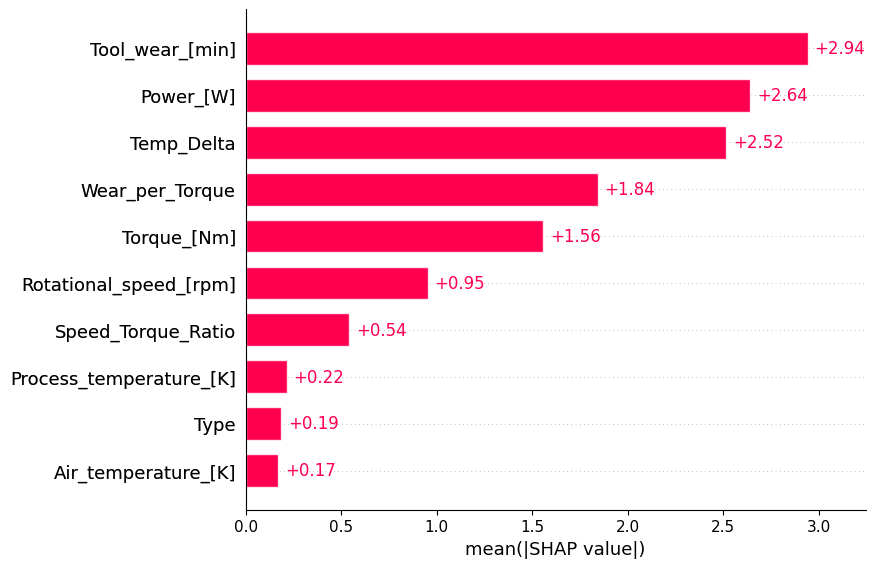

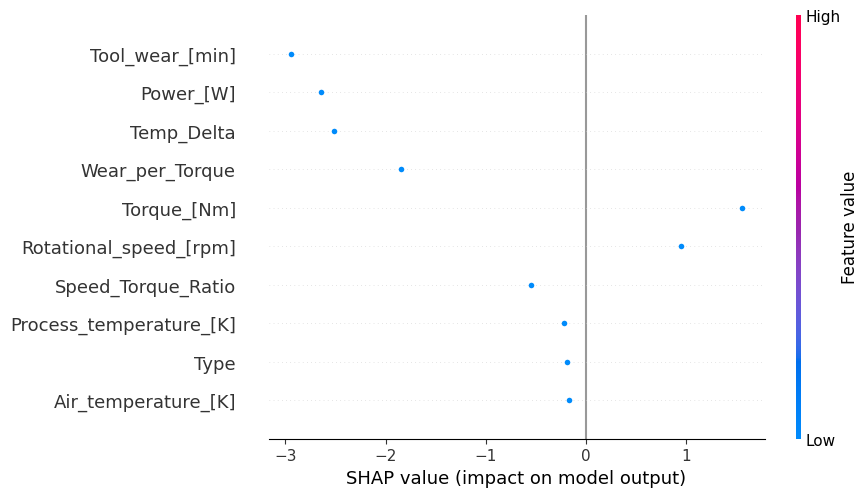

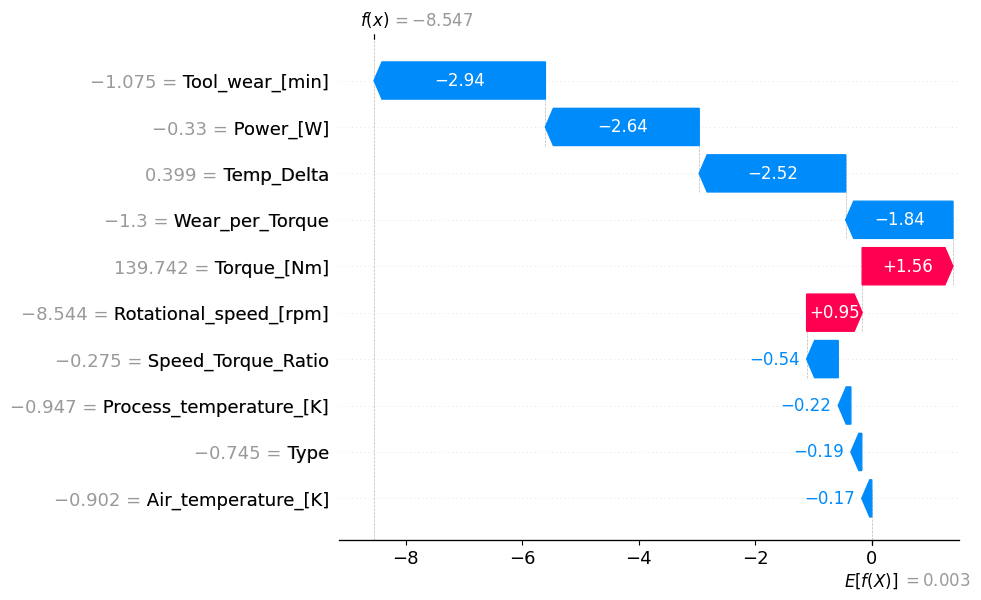

In [12]:
import numpy as np
import joblib
import shap
import pandas as pd

# === 1. Load saved scaler and model ===
scaler = joblib.load(r"C:\Users\PC\Desktop\3mtt_Hacka\preprocess\scaler_singleClass.joblib")
model = joblib.load(r"C:\Users\PC\Desktop\3mtt_Hacka\model\single_class_best_xgboost_model.joblib")

# === 2. Define feature names ===
feature_names = [
    "Type", 
    "Air_temperature_[K]", 
    "Process_temperature_[K]",
    "Rotational_speed_[rpm]", 
    "Torque_[Nm]", 
    "Tool_wear_[min]",
    "Temp_Delta", 
    "Power_[W]", 
    "Wear_per_Torque", 
    "Speed_Torque_Ratio"
]

# === 3. Raw sample data ===
sample = np.array([[
    0, 298.2, 308.6, 7, 1433, 39.5, 10.4, 5927.50465891566, 0.177215145008824, 36.2784718282349
]])

# Convert to DataFrame to include feature names
sample_df = pd.DataFrame(sample, columns=feature_names)

# === 4. Scale sample using saved scaler ===
sample_scaled = scaler.transform(sample_df)

# === 5. Predict using the loaded model ===
prediction = model.predict(sample_scaled)
print("Prediction:", prediction)

# === 6. SHAP Explainer with feature names ===
explainer = shap.Explainer(model, feature_names=feature_names)
shap_values = explainer(sample_scaled)

# === 7. SHAP Visualizations ===
# Force plot for single prediction
shap.plots.force(shap_values[0])

# Bar plot (feature importance for this sample)
shap.plots.bar(shap_values)

# Beeswarm plot (for multiple samples; here it will just show single sample)
shap.plots.beeswarm(shap_values)

# --- Waterfall plot for the single prediction ---
shap.plots.waterfall(shap_values[0])


# Multi-class

Predicted index: 0
Predicted class: No_failure


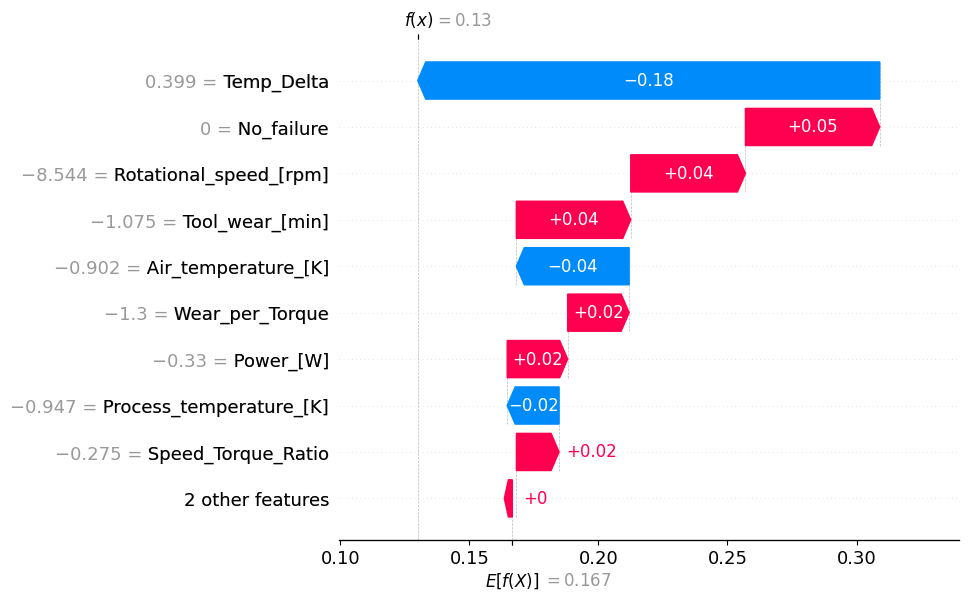


Bar and beeswarm plots skipped: only one sample is provided.


In [ ]:
import streamlit as st
import numpy as np
import pandas as pd
import joblib
import shap
import traceback

# ---------------------------
# Config - update paths if needed
# ---------------------------
SINGLE_SCALER_PATH = r"C:\Users\PC\Desktop\3mtt_Hacka\preprocess\scaler_singleClass.joblib"
SINGLE_MODEL_PATH = r"C:\Users\PC\Desktop\3mtt_Hacka\model\single_class_best_xgboost_model.joblib"

MULTI_SCALER_PATH = r"C:\Users\PC\Desktop\3mtt_Hacka\preprocess\scaler_singleClass.joblib"  # same scaler used earlier
MULTI_MODEL_PATH = r"C:\Users\PC\Desktop\3mtt_Hacka\model\multi_class_best_xgboost_model.joblib"

# ---------------------------
# Feature names & defaults
# ---------------------------
numeric_features = [
    "Type",
    "Air_temperature_[K]",
    "Process_temperature_[K]",
    "Rotational_speed_[rpm]",
    "Torque_[Nm]",
    "Tool_wear_[min]",
    "Temp_Delta",
    "Power_[W]",
    "Wear_per_Torque",
    "Speed_Torque_Ratio",
]

# for multi-class we add No_failure categorical feature (True/False)
multi_feature_names = numeric_features + ["No_failure"]
multi_target_classes = ["No_failure", "TWF", "RNF", "PWF", "HDF", "OSF"]

# default sample values taken from your example
DEFAULT_SAMPLE = {
    "Type": 0,
    "Air_temperature_[K]": 298.2,
    "Process_temperature_[K]": 308.6,
    "Rotational_speed_[rpm]": 7,
    "Torque_[Nm]": 1433,
    "Tool_wear_[min]": 39.5,
    "Temp_Delta": 10.4,
    "Power_[W]": 5927.50465891566,
    "Wear_per_Torque": 0.177215145008824,
    "Speed_Torque_Ratio": 36.2784718282349,
    "No_failure": False,
}

# ---------------------------
# Helper functions
# ---------------------------
@st.cache_resource
def load_model_and_scaler(single=True):
    """Load models and scalers (cached)."""
    if single:
        scaler = joblib.load(SINGLE_SCALER_PATH)
        model = joblib.load(SINGLE_MODEL_PATH)
        return scaler, model
    else:
        scaler = joblib.load(MULTI_SCALER_PATH)
        model = joblib.load(MULTI_MODEL_PATH)
        return scaler, model

def prepare_single_input(inputs_dict, scaler):
    """Return scaled numpy array for single-class model (shape: (1, n_features))."""
    df = pd.DataFrame([{
        k: inputs_dict[k] for k in numeric_features
    }])
    scaled = scaler.transform(df)
    return scaled, df

def prepare_multi_input(inputs_dict, scaler):
    """Return scaled DataFrame including No_failure column for multi-class model."""
    df = pd.DataFrame([{
        k: inputs_dict[k] for k in numeric_features
    }])
    # scale numeric cols
    df[numeric_features] = scaler.transform(df[numeric_features])
    # map No_failure boolean to 0/1
    df["No_failure"] = int(bool(inputs_dict.get("No_failure", False)))
    return df

def compute_shap_and_render(model, explainer, sample_input, predicted_index=None, feature_names=None):
    """Compute SHAP values (supports both single-output and multi-class) and render force + waterfall for first sample."""
    try:
        shap_values = explainer(sample_input)  # Explanation object

        # Detect multi-output vs single-output
        # shap_values.values shape:
        # - single-output: (samples, features)
        # - multi-output: (samples, features, classes)
        vals = getattr(shap_values, "values", None)
        expected = getattr(explainer, "expected_value", None)

        if vals is None:
            st.warning("SHAP returned no values.")
            return

        # Single-output case
        if vals.ndim == 2:
            # class index not needed; expected may be scalar or array
            class_shap = vals[0]  # (num_features,)
            base_value = expected if np.isscalar(expected) else expected[0]
            # Force plot (html)
            force_html = shap.force_plot(base_value, class_shap, sample_input.iloc[0], matplotlib=False)
            st.components.v1.html(shap.getjs() + force_html.html(), height=350)
            # Waterfall
            shap.plots.waterfall(shap.Explanation(
                values=class_shap,
                base_values=base_value,
                data=sample_input.iloc[0],
                feature_names=feature_names
            ))
        elif vals.ndim == 3:
            # multi-output: need predicted_index
            if predicted_index is None:
                st.error("Multi-output SHAP needs a predicted_index (class index).")
                return
            # Extract (samples, features) for that class and choose sample 0
            class_shap = vals[0, :, predicted_index]
            base_value = expected[predicted_index]
            force_html = shap.force_plot(base_value, class_shap, sample_input.iloc[0], matplotlib=False)
            st.components.v1.html(shap.getjs() + force_html.html(), height=350)
            shap.plots.waterfall(shap.Explanation(
                values=class_shap,
                base_values=base_value,
                data=sample_input.iloc[0],
                feature_names=feature_names
            ))
        else:
            st.error(f"Unexpected shap values shape: {vals.shape}")
    except Exception as e:
        st.error("Error rendering SHAP visuals:")
        st.text(traceback.format_exc())

# ---------------------------
# Streamlit UI
# ---------------------------
st.set_page_config(page_title="Machine Fault Detection - Single & Multi Model", layout="wide")
st.title("Machine Fault Detection — Single & Multi-class models")
st.markdown(
    """
This app lets you try both the binary (single-class) and multi-class models.
- **Single model**: `single_class_best_xgboost_model.joblib` (binary Good vs Fault)
- **Multi model**: `multi_class_best_xgboost_model.joblib` (No_failure, TWF, RNF, PWF, HDF, OSF)

Fill inputs, pick a model, and click **Predict**.
"""
)

# Sidebar for model selection
st.sidebar.header("Model selection & controls")
model_choice = st.sidebar.selectbox("Pick model", ["Single (binary) model", "Multi-class model"])

# Input fields (two-column layout)
col1, col2 = st.columns(2)
with col1:
    Type = st.number_input("Type", value=float(DEFAULT_SAMPLE["Type"]))
    Air_temperature = st.number_input("Air_temperature_[K]", value=float(DEFAULT_SAMPLE["Air_temperature_[K]"]))
    Process_temperature = st.number_input("Process_temperature_[K]", value=float(DEFAULT_SAMPLE["Process_temperature_[K]"]))
    Rotational_speed = st.number_input("Rotational_speed_[rpm]", value=float(DEFAULT_SAMPLE["Rotational_speed_[rpm]"]))
    Torque = st.number_input("Torque_[Nm]", value=float(DEFAULT_SAMPLE["Torque_[Nm]"]))
with col2:
    Tool_wear = st.number_input("Tool_wear_[min]", value=float(DEFAULT_SAMPLE["Tool_wear_[min]"]))
    Temp_Delta = st.number_input("Temp_Delta", value=float(DEFAULT_SAMPLE["Temp_Delta"]))
    Power = st.number_input("Power_[W]", value=float(DEFAULT_SAMPLE["Power_[W]"]))
    Wear_per_Torque = st.number_input("Wear_per_Torque", value=float(DEFAULT_SAMPLE["Wear_per_Torque"]))
    Speed_Torque_Ratio = st.number_input("Speed_Torque_Ratio", value=float(DEFAULT_SAMPLE["Speed_Torque_Ratio"]))

# Multi-specific checkbox
No_failure_checkbox = False
if model_choice.startswith("Multi"):
    No_failure_checkbox = st.checkbox("No_failure (True/False)", value=DEFAULT_SAMPLE["No_failure"])

# Predict button
if st.button("Predict"):

    # Build input dict
    inputs = {
        "Type": Type,
        "Air_temperature_[K]": Air_temperature,
        "Process_temperature_[K]": Process_temperature,
        "Rotational_speed_[rpm]": Rotational_speed,
        "Torque_[Nm]": Torque,
        "Tool_wear_[min]": Tool_wear,
        "Temp_Delta": Temp_Delta,
        "Power_[W]": Power,
        "Wear_per_Torque": Wear_per_Torque,
        "Speed_Torque_Ratio": Speed_Torque_Ratio,
        "No_failure": No_failure_checkbox
    }

    # Load proper model & scaler
    try:
        if model_choice.startswith("Single"):
            scaler, model = load_model_and_scaler(single=True)

            # prepare input
            scaled_array, original_df = prepare_single_input(inputs, scaler)  # scaled numpy array and original DataFrame
            # Predict (binary)
            pred = model.predict(scaled_array)  # shape may be (1,) with 0 or 1, or probability if using predict_proba
            # Probability if available
            proba = None
            if hasattr(model, "predict_proba"):
                proba = model.predict_proba(scaled_array)[0]

            # Decide status
            # If model.predict returns [0] or 0 => Good condition. If 1 => Fault.
            pred_val = int(np.asarray(pred).ravel()[0])
            status = "Good condition" if pred_val == 0 else "Fault identified"
            st.subheader("Prediction (Single / Binary)")
            st.write(f"Status: **{status}**")
            st.write(f"Raw model output (predict): {pred_val}")
            if proba is not None:
                st.write("Probabilities:", proba)

            # SHAP
            st.markdown("### SHAP explanation (Single model)")
            try:
                explainer = shap.Explainer(model, feature_names=numeric_features)
                # Note: the explainer expects the same input shape used for training - scaled arrays or raw depending on how it was built.
                # We call explainer on a pandas DataFrame with scaled numeric columns for convenience.
                scaled_df = pd.DataFrame(scaled_array, columns=numeric_features)
                compute_shap_and_render(model, explainer, scaled_df, predicted_index=None, feature_names=numeric_features)
            except Exception:
                st.error("Error creating SHAP explainer for single model.")
                st.text(traceback.format_exc())

        else:
            # Multi model
            scaler, model = load_model_and_scaler(single=False)
            df_multi = prepare_multi_input(inputs, scaler)  # DataFrame scaled + No_failure
            # Predict - earlier you had model.predict(sample_df)[0] -> a one-hot like vector
            raw_pred = model.predict(df_multi)  # often for xgboost multiclass this returns array of class indices or class probabilities depending on API
            # Try to interpret predictions:
            # If raw_pred is array-like with shape (1, n_classes) -> assume it's one-hot/probabilities or probabilities.
            raw_pred_arr = np.asarray(raw_pred)
            st.subheader("Prediction (Multi-class)")
            predicted_class = None
            predicted_index = None
            prediction_probs = None

            # Case 1: model.predict returns probabilities or one-hot row (like [0,1,0,...])
            if raw_pred_arr.ndim == 2 and raw_pred_arr.shape[1] == len(multi_target_classes):
                # If values are probabilities or one-hot, take argmax for class
                predicted_index = int(np.argmax(raw_pred_arr[0]))
                predicted_class = multi_target_classes[predicted_index]
                prediction_probs = raw_pred_arr[0]
            else:
                # If model.predict returns a single integer label (class index) or string label:
                val = raw_pred_arr.ravel()[0]
                # If it's numeric and in range, treat as index
                if np.issubdtype(type(val), np.integer) or (isinstance(val, (int, np.integer))):
                    predicted_index = int(val)
                    if 0 <= predicted_index < len(multi_target_classes):
                        predicted_class = multi_target_classes[predicted_index]
                else:
                    # maybe it returned a class name (string)
                    try:
                        predicted_class = str(val)
                        if predicted_class in multi_target_classes:
                            predicted_index = multi_target_classes.index(predicted_class)
                    except Exception:
                        predicted_class = str(val)

            # If no predicted_index found, fallback to predict_proba if available
            if predicted_index is None and hasattr(model, "predict_proba"):
                try:
                    probs = model.predict_proba(df_multi)
                    # probs might be shape (1, n_classes)
                    if probs.ndim == 2 and probs.shape[1] == len(multi_target_classes):
                        prediction_probs = probs[0]
                        predicted_index = int(np.argmax(prediction_probs))
                        predicted_class = multi_target_classes[predicted_index]
                except Exception:
                    pass

            if predicted_class is None:
                st.error("Could not interpret model prediction reliably.")
                st.write("Raw model output:", raw_pred)
            else:
                # Determine friendly status: Good condition if class is No_failure, else Fault identified
                status = "Good condition" if predicted_class == "No_failure" else "Fault identified"
                st.write(f"Status: **{status}**")
                st.write(f"Predicted class: **{predicted_class}** (index {predicted_index})")
                if prediction_probs is not None:
                    probs_df = pd.DataFrame([prediction_probs], columns=multi_target_classes)
                    st.write("Prediction probabilities:")
                    st.dataframe(probs_df.T.rename(columns={0: "probability"}))

            # SHAP for multi-class
            st.markdown("### SHAP explanation (Multi-class)")
            try:
                explainer = shap.Explainer(model, feature_names=multi_feature_names)
                # Note: pass the full DataFrame including No_failure (scaled numeric + 0/1)
                compute_shap_and_render(model, explainer, df_multi, predicted_index=predicted_index, feature_names=multi_feature_names)
            except Exception:
                st.error("Error creating SHAP explainer for multi-class model.")
                st.text(traceback.format_exc())

    except Exception as e:
        st.error("Prediction failed:")
        st.text(traceback.format_exc())

# Footer
st.markdown("---")
st.markdown("Built for testing both single and multi-class xgboost models with SHAP explanation. Update model/scaler paths at the top if different.")


Predicted status: Fault identified
Predicted fault type: No_failure


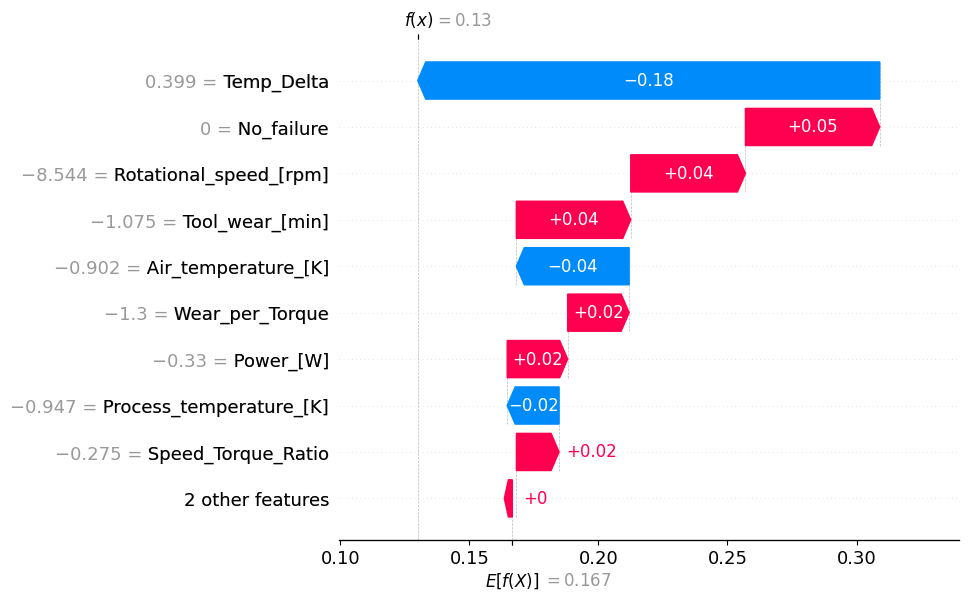


Bar and beeswarm plots skipped: only one sample is provided.


In [30]:
import numpy as np
import pandas as pd
import joblib
import shap

# === 1. Load saved scaler and model ===
scaler = joblib.load(r"C:\Users\PC\Desktop\3mtt_Hacka\preprocess\scaler_singleClass.joblib")
model = joblib.load(r"C:\Users\PC\Desktop\3mtt_Hacka\model\multi_class_best_xgboost_model.joblib")

# === 2. Define feature names ===
numeric_features = [
    "Type", 
    "Air_temperature_[K]", 
    "Process_temperature_[K]",
    "Rotational_speed_[rpm]", 
    "Torque_[Nm]", 
    "Tool_wear_[min]",
    "Temp_Delta", 
    "Power_[W]", 
    "Wear_per_Torque", 
    "Speed_Torque_Ratio"
]
categorical_features = ["No_failure"]
feature_names = numeric_features + categorical_features

# === 3. Multi-class target labels (including 'No_failure') ===
target_classes = ["No_failure", "TWF", "RNF", "PWF", "HDF", "OSF"]

# === 4. Raw sample data ===
sample = np.array([[ 
    0, 298.2, 308.6, 7, 1433, 39.5, 10.4, 5927.50465891566, 0.177215145008824, 36.2784718282349, "False"
]])
sample_df = pd.DataFrame(sample, columns=feature_names)

# === 5. Map categorical feature to numeric (0/1) ===
sample_df["No_failure"] = sample_df["No_failure"].map({"False": 0, "True": 1})

# === 6. Scale numeric features only ===
sample_df[numeric_features] = scaler.transform(sample_df[numeric_features])

# === 7. Predict using the loaded model (one-hot vector) ===
prediction_vector = model.predict(sample_df)[0]  # single sample

# Determine status based on 'No_failure'
if prediction_vector[0] == 0:  # 'No_failure' detected
    status = "Good condition"
else:
    status = "Fault identified"

# Get the predicted fault class
predicted_index = np.argmax(prediction_vector)
predicted_class = target_classes[predicted_index]

print(f"Predicted status: {status}")
if status == "Fault identified":
    print(f"Predicted fault type: {predicted_class}")

# === 8. SHAP Explainer for multi-class model ===
explainer = shap.Explainer(model, feature_names=feature_names)
shap_values = explainer(sample_df)

# === 9. Initialize SHAP JS for interactive plots ===
shap.initjs()

# === 10. Visualize SHAP for predicted class only ===
i = predicted_index  # use the predicted class index

# Force plot
shap.plots.force(
    explainer.expected_value[i],
    shap_values.values[..., i],
    feature_names=feature_names
)

# Waterfall plot
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values.values[0, :, i],
        base_values=explainer.expected_value[i],
        data=sample_df.iloc[0],
        feature_names=feature_names
    )
)

print("\nBar and beeswarm plots skipped: only one sample is provided.")
